# Automated CapsnetsS2I train + test

First, import stuff

In [15]:
import model_s2i
import data_loader
import tensorflow as tf

In [16]:
import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

## Load word vectors and data

In [17]:
WORD_VEC_SCENARIO = "FastText-300-verbsDatasets-synAntVSP-dia"
SCENARIO_NAME = '1-attention-head'

word2vec_path = '../../romanian_word_vecs/cleaned-vectors-diacritice.vec'

# No diacritics data
training_data_paths = [
#         '../data-capsnets/scenario0/train.txt',
#         '../data-capsnets/scenario1/train.txt',
#         '../data-capsnets/scenario2/train.txt',
#         '../data-capsnets/scenario3.1/train.txt',
#         '../data-capsnets/scenario3.2/train.txt',
#         '../data-capsnets/scenario3.3/train.txt',
        '../data-capsnets/diacritics/scenario0/train.txt',
        '../data-capsnets/diacritics/scenario1/train.txt',
        '../data-capsnets/diacritics/scenario2/train.txt',
        '../data-capsnets/diacritics/scenario31/train.txt',
        '../data-capsnets/diacritics/scenario32/train.txt',
        '../data-capsnets/diacritics/scenario33/train.txt',
        
    ]
test_data_paths = [
#     '../data-capsnets/scenario0/test.txt',
#     '../data-capsnets/scenario1/test.txt',
#     '../data-capsnets/scenario2/test.txt',
#     '../data-capsnets/scenario3.1/test.txt',
#     '../data-capsnets/scenario3.2/test.txt',
#     '../data-capsnets/scenario3.3/test.txt',
    '../data-capsnets/diacritics/scenario0/test.txt',
    '../data-capsnets/diacritics/scenario1/test.txt',
    '../data-capsnets/diacritics/scenario2/test.txt',
    '../data-capsnets/diacritics/scenario31/test.txt',
    '../data-capsnets/diacritics/scenario32/test.txt',
    '../data-capsnets/diacritics/scenario33/test.txt',
]

scenario_nums = [
#     '0_' + WORD_VEC_SCENARIO,
#     '1_' + WORD_VEC_SCENARIO,
#     '2_' + WORD_VEC_SCENARIO,
#     '31_' + WORD_VEC_SCENARIO,
#     '32_' + WORD_VEC_SCENARIO,
#     '33_' + WORD_VEC_SCENARIO,
#     '0_dia_' + WORD_VEC_SCENARIO,
#     '1_dia_' + WORD_VEC_SCENARIO,
#     '2_dia_' + WORD_VEC_SCENARIO,
#     '31_dia_' + WORD_VEC_SCENARIO,
#     '32_dia_' + WORD_VEC_SCENARIO,
#     '33_dia_' + WORD_VEC_SCENARIO,
    '0-' + SCENARIO_NAME,
    '1-' + SCENARIO_NAME,
    '2-' + SCENARIO_NAME,
    '31-' + SCENARIO_NAME,
    '32-' + SCENARIO_NAME,
    '33-' + SCENARIO_NAME,
]

In [18]:
print('------------------load word2vec begin-------------------')
w2v = data_loader.load_w2v(word2vec_path)
print('------------------load word2vec end---------------------')

------------------load word2vec begin-------------------
loading time took 000.08
------------------load word2vec end---------------------


# Flag setting functions + utils

In [20]:
import csv

def set_flags(data, scenario):
    FLAGS = tf.app.flags.FLAGS

    tf.app.flags.DEFINE_boolean('save_model', False, 'save model to disk')
    tf.app.flags.DEFINE_string('summaries_dir', './logs', 'tensorboard summaries')
    tf.app.flags.DEFINE_string('ckpt_dir', './saved_models/', 'check point dir')
    tf.app.flags.DEFINE_string('scenario_num', scenario, 'Scenario number')
    tf.app.flags.DEFINE_string('errors_dir', './errors/', 'Errors dir')
    tf.app.flags.DEFINE_string('results_dir', './results/', 'Results dir')
    tf.app.flags.DEFINE_string('hyperparams_dir', './hyperparams/', 'Hyperparams dir')
    
    vocab_size, word_emb_size = data['embedding'].shape
    _, max_sentence_length = data['x_tr'].shape
    intents_number = len(data['intents_dict'])
    slots_number = len(data['slots_dict'])
    hidden_size = 64

    tf.app.flags.DEFINE_float('keep_prob', 1, 'embedding dropout keep rate for training')
    tf.app.flags.DEFINE_integer('hidden_size', hidden_size, 'embedding vector size')
    tf.app.flags.DEFINE_integer('batch_size', 32, 'batch size')
    tf.app.flags.DEFINE_integer('num_epochs', 20, 'num of epochs')
    tf.app.flags.DEFINE_integer('vocab_size', vocab_size, 'vocab size of word vectors')
    tf.app.flags.DEFINE_integer('max_sentence_length', max_sentence_length, 'max number of words in one sentence')
    tf.app.flags.DEFINE_integer('intents_nr', intents_number, 'intents_number')  #
    tf.app.flags.DEFINE_integer('slots_nr', slots_number, 'slots_number')  #
    tf.app.flags.DEFINE_integer('word_emb_size', word_emb_size, 'embedding size of word vectors')
    tf.app.flags.DEFINE_boolean('use_embedding', True, 'whether to use embedding or not.')
    tf.app.flags.DEFINE_float('learning_rate', 0.01, 'learning rate')
    tf.app.flags.DEFINE_integer('slot_routing_num', 2, 'slot routing num')
    tf.app.flags.DEFINE_integer('intent_routing_num', 3, 'intent routing num')
    tf.app.flags.DEFINE_integer('intent_output_dim', 16, 'intent output dimension')
    tf.app.flags.DEFINE_integer('slot_output_dim', 2 * hidden_size, 'slot output dimension')
    tf.app.flags.DEFINE_integer('d_a', 20, 'self attention weight hidden units number')
    tf.app.flags.DEFINE_integer('r', 1, 'number of self attention heads')
    tf.app.flags.DEFINE_float('alpha', 0.0001, 'coefficient for self attention loss')
    tf.app.flags.DEFINE_integer('n_splits', 3, 'Number of cross-validation splits')
    tf.app.flags.DEFINE_float('rerouting_coef', 0.5, 'coefficient for rerouting')
    tf.app.flags.DEFINE_boolean('use_rerouting', True, 'whether to use rerouting or not')
    tf.app.flags.DEFINE_boolean('use_attention', True,
                                'whether to use attention or not. If attention is used,'
                                'slot_output_dim will be overridden to hidden_size * 2')
    
    tf.app.flags.DEFINE_string('f', '', 'kernel') # Without this there's an error: unknown command line flag 'f'
    
    return FLAGS

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)
        
def write_csv(run_results):
    with open('results/results_{}.csv'.format(SCENARIO_NAME), 'w') as f:
        header_line = ['Scenario', 'Intent F1', 'Slot F1']
        writer = csv.writer(f)
        writer.writerow(header_line)
        for k, v in run_results.items():
            scenario_num = [k]
            intent_score = [v['intent_f1']]
            slot_score = [v['slot_f1']]
            l = scenario_num + intent_score + slot_score
            writer.writerow(l)

In [19]:
# In case it's needed
del_all_flags(FLAGS)

------------------read datasets begin-------------------
max length is 15
max length is 15
------------------read datasets end---------------------
TRAINING 0-1-attention-head
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.071429
F score 0.071429
Slot filling
F1 score: 0.005401
Accuracy: 0.064286
------------------epoch :  0  Loss:  18.46771 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.402381
F score 0.402381
Slot filling
F1 score: 0.343612
Accuracy: 0.918095
Current F score mean 0.37299664359135726
Best F score mean 0.37299664359135726
------------------epoch :  1  Loss:  3.2510436 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.704762
F score 0.704762
Slot filling


------------------epoch :  5  Loss:  0.052891567 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.959524
F score 0.959524
Slot filling
F1 score: 0.984833
Accuracy: 0.999048
Current F score mean 0.972178487168376
Best F score mean 0.9889189452649023
------------------epoch :  6  Loss:  0.0073025995 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.940476
F score 0.940476
Slot filling
F1 score: 0.989837
Accuracy: 0.999048
Current F score mean 0.9651567944250872
Best F score mean 0.9889189452649023
------------------epoch :  7  Loss:  0.031694897 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.976190
F score 0.976190
Slot filling
F1 score: 0.990863
Accuracy: 0.999206
Current F score mean 0.9835267101764564
Best F score mean 0.9889189452649023
------------------epoch :  8  Loss:  0.0061870455 ----------------------
           V

------------------epoch :  11  Loss:  0.0019556822 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992857
F score 0.992857
Slot filling
F1 score: 0.983871
Accuracy: 0.998889
Current F score mean 0.9883640552995392
Best F score mean 0.9950758126241341
------------------epoch :  12  Loss:  0.0016719229 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992857
F score 0.992857
Slot filling
F1 score: 0.983871
Accuracy: 0.998889
Current F score mean 0.9883640552995392
Best F score mean 0.9950758126241341
------------------epoch :  13  Loss:  0.0014592801 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992857
F score 0.992857
Slot filling
F1 score: 0.983871
Accuracy: 0.998889
Current F score mean 0.9883640552995392
Best F score mean 0.9950758126241341
------------------epoch :  14  Loss:  0.0012877312 ----------------------
     

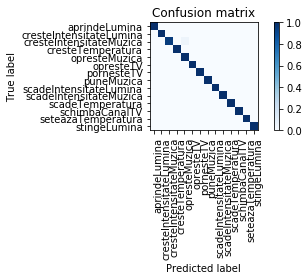

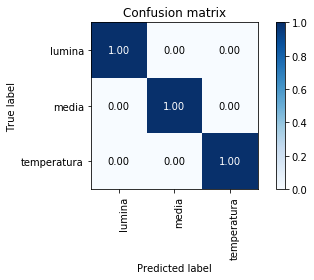

Intent F1: 0.996429
Slot F1: 0.996180
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 1-1-attention-head
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.081081
F score 0.081081
Slot filling
F1 score: 0.023213
Accuracy: 0.119691
------------------epoch :  0  Loss:  20.363874 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.537838
F score 0.537838
Slot filling
F1 score: 0.401254
Accuracy: 0.904826
Current F score mean 0.4695458781665678
Best F score mean 0.4695458781665678
------------------epoch :  1  Loss:  2.2819638 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.976166
Accuracy: 0.997683
Current F score mean 0.9880829015544041
Best F score mean 0.9974619289340102
------------------epoch :  5  Loss:  0.0058242846 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.980270
Accuracy: 0.998263
Current F score mean 0.990134994807892
Best F score mean 0.9974619289340102
------------------epoch :  6  Loss:  0.0045208475 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.982347
Accuracy: 0.998649
Current F score mean 0.9911734164070614
Best F score mean 0.9974619289340102
------------------epoch :  7  Loss:  0.0034672199 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.00

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.989712
Accuracy: 0.999224
Current F score mean 0.9948559670781894
Best F score mean 0.9974619289340102
------------------epoch :  11  Loss:  0.0025433565 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.992791
Accuracy: 0.999418
Current F score mean 0.9963954685890835
Best F score mean 0.9974619289340102
------------------epoch :  12  Loss:  0.0021467453 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.992791
Accuracy: 0.999418
Current F score mean 0.9963954685890835
Best F score mean 0.9974619289340102
------------------epoch :  13  Loss:  0.0018441055 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 

<Figure size 432x288 with 0 Axes>

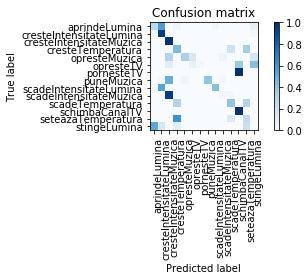

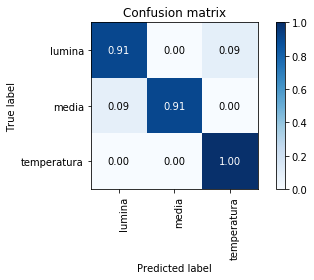

Intent F1: 0.398214
Slot F1: 0.768790
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 2-1-attention-head
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.090634
F score 0.090634
Slot filling
F1 score: 0.027163
Accuracy: 0.241260
------------------epoch :  0  Loss:  22.940899 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.549849
F score 0.549849
Slot filling
F1 score: 0.401042
Accuracy: 0.913250
Current F score mean 0.47544530463242696
Best F score mean 0.47544530463242696
------------------epoch :  1  Loss:  3.3269448 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.975831
F score 0.975831
Slot filling
F1 score: 0.993392
Accuracy: 0.998489
Current F score mean 0.9846114430972757
Best F score mean 0.9854682779456193
------------------epoch :  5  Loss:  0.025652356 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.978852
F score 0.978852
Slot filling
F1 score: 0.993392
Accuracy: 0.998705
Current F score mean 0.9861220171154025
Best F score mean 0.9861220171154025
------------------epoch :  6  Loss:  0.08362748 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.996979
F score 0.996979
Slot filling
F1 score: 0.996692
Accuracy: 0.999137
Current F score mean 0.9968356222332513
Best F score mean 0.9968356222332513
------------------epoch :  7  Loss:  0.018239638 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.99697

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.997821
Accuracy: 0.999568
Current F score mean 0.9989106753812635
Best F score mean 0.9989106753812635
------------------epoch :  11  Loss:  0.0045417496 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.997821
Accuracy: 0.999568
Current F score mean 0.9989106753812635
Best F score mean 0.9989106753812635
------------------epoch :  12  Loss:  0.0037805918 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.997821
Accuracy: 0.999568
Current F score mean 0.9989106753812635
Best F score mean 0.9989106753812635
------------------epoch :  13  Loss:  0.003183405 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1

<Figure size 432x288 with 0 Axes>

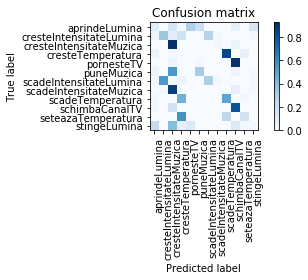

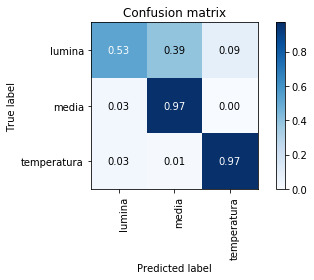

Intent F1: 0.291667
Slot F1: 0.466437
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 31-1-attention-head
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.111524
F score 0.111524
Slot filling
F1 score: 0.014660
Accuracy: 0.076474
------------------epoch :  0  Loss:  24.647861 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.457249
F score 0.457249
Slot filling
F1 score: 0.416807
Accuracy: 0.917419
Current F score mean 0.4370278966605229
Best F score mean 0.4370278966605229
------------------epoch :  1  Loss:  8.020558 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.985130
F score 0.985130
Slot filling
F1 score: 0.969697
Accuracy: 0.997345
Current F score mean 0.9774135406105666
Best F score mean 0.9898225648276963
------------------epoch :  5  Loss:  0.10866128 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.977695
F score 0.977695
Slot filling
F1 score: 0.990854
Accuracy: 0.998407
Current F score mean 0.9842744129114154
Best F score mean 0.9898225648276963
------------------epoch :  6  Loss:  0.033342466 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.977695
F score 0.977695
Slot filling
F1 score: 0.986301
Accuracy: 0.998407
Current F score mean 0.9819982685746296
Best F score mean 0.9898225648276963
------------------epoch :  7  Loss:  0.024489151 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.97769

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.996255
F score 0.996255
Slot filling
F1 score: 0.975904
Accuracy: 0.997057
Current F score mean 0.9860791480528857
Best F score mean 0.9898225648276963
------------------epoch :  11  Loss:  0.014215702 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.996255
F score 0.996255
Slot filling
F1 score: 0.980451
Accuracy: 0.997592
Current F score mean 0.9883529047337445
Best F score mean 0.9898225648276963
------------------epoch :  12  Loss:  0.008316099 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.996255
F score 0.996255
Slot filling
F1 score: 0.980451
Accuracy: 0.997592
Current F score mean 0.9883529047337445
Best F score mean 0.9898225648276963
------------------epoch :  13  Loss:  0.006298666 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.9

<Figure size 432x288 with 0 Axes>

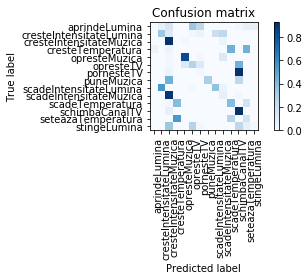

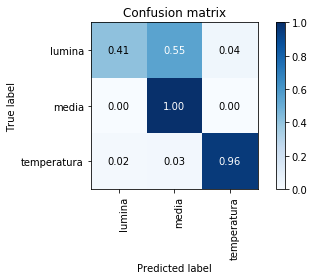

Intent F1: 0.333929
Slot F1: 0.439024
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 32-1-attention-head
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.111111
F score 0.111111
Slot filling
F1 score: 0.006128
Accuracy: 0.013757
------------------epoch :  0  Loss:  20.649887 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.385185
F score 0.385185
Slot filling
F1 score: 0.610753
Accuracy: 0.952646
Current F score mean 0.4979689366786141
Best F score mean 0.4979689366786141
------------------epoch :  1  Loss:  8.131225 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.

------------------epoch :  5  Loss:  0.12240301 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.944444
F score 0.944444
Slot filling
F1 score: 0.952224
Accuracy: 0.994180
Current F score mean 0.9483342485813655
Best F score mean 0.974985899605189
------------------epoch :  6  Loss:  0.055377282 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.966667
F score 0.966667
Slot filling
F1 score: 0.957096
Accuracy: 0.994444
Current F score mean 0.9618811881188118
Best F score mean 0.974985899605189
------------------epoch :  7  Loss:  0.026754633 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992593
F score 0.992593
Slot filling
F1 score: 0.955665
Accuracy: 0.994974
Current F score mean 0.9741288086115671
Best F score mean 0.974985899605189
------------------epoch :  8  Loss:  0.016494222 ----------------------
           VALIDA

------------------epoch :  11  Loss:  0.019623999 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.973881
F score 0.973881
Slot filling
F1 score: 0.970100
Accuracy: 0.997068
Current F score mean 0.9719901323945059
Best F score mean 0.9820885960095187
------------------epoch :  12  Loss:  0.0138458265 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.973881
F score 0.973881
Slot filling
F1 score: 0.961983
Accuracy: 0.996535
Current F score mean 0.9679320340446527
Best F score mean 0.9820885960095187
------------------epoch :  13  Loss:  0.011045265 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.973881
F score 0.973881
Slot filling
F1 score: 0.961983
Accuracy: 0.996535
Current F score mean 0.9679320340446527
Best F score mean 0.9820885960095187
------------------epoch :  14  Loss:  0.009403346 ----------------------
        

<Figure size 432x288 with 0 Axes>

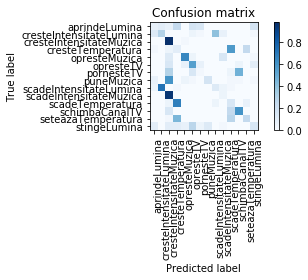

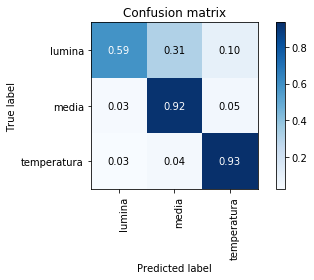

Intent F1: 0.298214
Slot F1: 0.446768
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 33-1-attention-head
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.015152
F score 0.015152
Slot filling
F1 score: 0.015537
Accuracy: 0.028860
------------------epoch :  0  Loss:  22.138737 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.323232
F score 0.323232
Slot filling
F1 score: 0.241715
Accuracy: 0.874098
Current F score mean 0.2824738614212299
Best F score mean 0.2824738614212299
------------------epoch :  1  Loss:  9.741639 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.924242
F score 0.924242
Slot filling
F1 score: 0.965204
Accuracy: 0.994228
Current F score mean 0.9447233301242378
Best F score mean 0.9793381576963667
------------------epoch :  5  Loss:  0.22443946 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.924242
F score 0.924242
Slot filling
F1 score: 0.977376
Accuracy: 0.995310
Current F score mean 0.9508089949266421
Best F score mean 0.9793381576963667
------------------epoch :  6  Loss:  0.26848996 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.944444
F score 0.944444
Slot filling
F1 score: 0.986425
Accuracy: 0.997114
Current F score mean 0.9654348919054802
Best F score mean 0.9793381576963667
------------------epoch :  7  Loss:  0.47826648 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.964646


------------------epoch :  11  Loss:  0.023953782 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.979798
F score 0.979798
Slot filling
F1 score: 0.974436
Accuracy: 0.996032
Current F score mean 0.9771170350117719
Best F score mean 0.9820947026829379
------------------epoch :  12  Loss:  0.020091902 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.979798
F score 0.979798
Slot filling
F1 score: 0.974436
Accuracy: 0.996032
Current F score mean 0.9771170350117719
Best F score mean 0.9820947026829379
------------------epoch :  13  Loss:  0.016062925 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.974747
F score 0.974747
Slot filling
F1 score: 0.974436
Accuracy: 0.996032
Current F score mean 0.9745917824865193
Best F score mean 0.9820947026829379
------------------epoch :  14  Loss:  0.013707785 ----------------------
         

<Figure size 432x288 with 0 Axes>

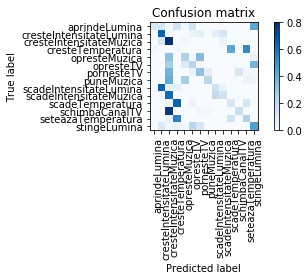

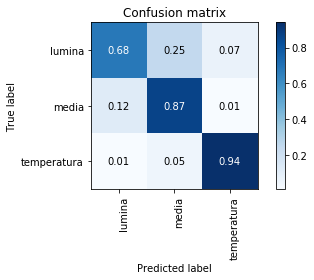

Intent F1: 0.279070
Slot F1: 0.510936


<Figure size 432x288 with 0 Axes>

In [21]:
import train
import test

results = dict()
for i in range(len(training_data_paths)):
    
    # Load data
    data = data_loader.read_datasets(w2v, training_data_paths[i], test_data_paths[i], test=True)
    
    FLAGS = set_flags(data, scenario=scenario_nums[i])
    
    # Train model
    print('TRAINING ' + scenario_nums[i])
    train.train(model_s2i.CapsNetS2I, data, FLAGS, batches_rand=False)
    
    # Test model
    print('TESTING ' + scenario_nums[i])
    intent_f, slot_f = test.test(model_s2i.CapsNetS2I, data, FLAGS)
    results[scenario_nums[i]] = dict()
    results[scenario_nums[i]]['intent_f1'] = intent_f
    results[scenario_nums[i]]['slot_f1'] = slot_f
        
    # Reset flags
    del_all_flags(FLAGS)

write_csv(results)